In [1]:
# Cell 1: Notebook Introduction (Markdown)

In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cell 2: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
import xgboost as xgb
import joblib
import time
import warnings
warnings.filterwarnings('ignore')

# Set up visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [3]:
# Cell 3: Load Clean Dataset
# Load the cleaned dataset
df = pd.read_csv('../data/patient_readmission_risk_clean.csv')

print("📊 Clean Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Display first few rows
print("\n👀 First 3 rows:")
display(df.head(3))

# Check target distribution
print("\n🎯 Target Distribution:")
target_dist = df['high_risk_readmission'].value_counts()
print(target_dist)
print(f"Balance Ratio: {target_dist[0]/target_dist[1]:.2f}:1")

📊 Clean Dataset Info:
Shape: (2000, 33)
Columns: ['patient_id', 'age', 'gender', 'ethnicity', 'admission_type', 'admission_date', 'length_of_stay', 'num_previous_admissions', 'primary_diagnosis', 'secondary_diagnosis', 'num_lab_procedures', 'num_medications', 'num_outpatient_visits', 'num_emergency_visits', 'num_inpatient_visits', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'bmi', 'glucose_level', 'cholesterol_level', 'heart_rate', 'oxygen_saturation', 'smoking_status', 'alcohol_intake', 'physical_activity_level', 'diet_quality', 'living_alone', 'treatment_type', 'discharge_disposition', 'followup_appointment_scheduled', 'followup_days', 'high_risk_readmission', 'discharge_date']

👀 First 3 rows:


,patient_id,age,gender,ethnicity,admission_type,admission_date,length_of_stay,num_previous_admissions,primary_diagnosis,secondary_diagnosis,...,alcohol_intake,physical_activity_level,diet_quality,living_alone,treatment_type,discharge_disposition,followup_appointment_scheduled,followup_days,high_risk_readmission,discharge_date
0,1001,71,Male,African American,Urgent,2024-01-21,1,3,Heart Failure,NaN,...,Moderate,Low,Good,0,Medication,Home,0,1,1,2024-01-22
1,1002,34,Male,African American,Emergency,2024-04-09,7,0,Heart Failure,Obesity,...,High,Low,Poor,0,Medication,Nursing Home,0,37,0,2024-04-16
2,1003,80,Female,Hispanic,Emergency,2024-10-26,10,4,COPD,Kidney Disease,...,Moderate,High,Good,1,Medication,Nursing Home,1,20,1,2024-11-05



🎯 Target Distribution:
high_risk_readmission
0    1052
1     948
Name: count, dtype: int64
Balance Ratio: 1.11:1


In [4]:
# Cell 4: Prepare Features and Target
# Separate features and target
X = df.drop('high_risk_readmission', axis=1)
y = df['high_risk_readmission']

print("📈 Features Shape:", X.shape)
print("🎯 Target Shape:", y.shape)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n📊 Categorical Features ({len(categorical_cols)}): {categorical_cols}")
print(f"📈 Numerical Features ({len(numerical_cols)}): {numerical_cols}")

# Check for date columns and handle them
date_cols = [col for col in X.columns if 'date' in col.lower()]
if date_cols:
    print(f"📅 Date columns found: {date_cols}")
    # We'll handle these in preprocessing

📈 Features Shape: (2000, 32)
🎯 Target Shape: (2000,)

📊 Categorical Features (13): ['gender', 'ethnicity', 'admission_type', 'admission_date', 'primary_diagnosis', 'secondary_diagnosis', 'smoking_status', 'alcohol_intake', 'physical_activity_level', 'diet_quality', 'treatment_type', 'discharge_disposition', 'discharge_date']
📈 Numerical Features (19): ['patient_id', 'age', 'length_of_stay', 'num_previous_admissions', 'num_lab_procedures', 'num_medications', 'num_outpatient_visits', 'num_emergency_visits', 'num_inpatient_visits', 'blood_pressure_systolic', 'blood_pressure_diastolic', 'bmi', 'glucose_level', 'cholesterol_level', 'heart_rate', 'oxygen_saturation', 'living_alone', 'followup_appointment_scheduled', 'followup_days']
📅 Date columns found: ['admission_date', 'discharge_date']


In [5]:
# Cell 5: Train-Test Split
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintain class distribution
)

print("📊 Data Split Summary:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Training target distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Test target distribution: {pd.Series(y_test).value_counts().to_dict()}")

📊 Data Split Summary:
Training set: 1600 samples (80.0%)
Test set: 400 samples (20.0%)
Training target distribution: {0: 842, 1: 758}
Test target distribution: {0: 210, 1: 190}


In [6]:
# Cell 6: Create Preprocessing Pipeline
# Create preprocessing pipelines
numerical_transformer = StandardScaler()

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

print("🛠️ Preprocessing Pipeline Created:")
print(preprocessor)

🛠️ Preprocessing Pipeline Created:
ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['patient_id', 'age', 'length_of_stay',
                                  'num_previous_admissions',
                                  'num_lab_procedures', 'num_medications',
                                  'num_outpatient_visits',
                                  'num_emergency_visits',
                                  'num_inpatient_visits',
                                  'blood_pressure_systolic',
                                  'blood_pressure_diastolic', 'bmi',
                                  'glucose_level', 'cholesterol_level',
                                  'heart_rate', 'oxygen_satura...
                                  'followup_appointment_scheduled',
                                  'followup_days']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                  

In [7]:
# Cell 7: Define Models for Comparison
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

print("🤖 Models to be trained:")
for name, model in models.items():
    print(f"  - {name}")

🤖 Models to be trained:
  - Logistic Regression
  - Random Forest
  - XGBoost


In [9]:
# Cell 8: Model Training Function
def train_and_evaluate_models(models, preprocessor, X_train, X_test, y_train, y_test):
    """
    Train multiple models and evaluate their performance
    """
    results = {}
    training_times = {}
    
    for name, model in models.items():
        print(f"\n🚀 Training {name}...")
        
        # Create pipeline with preprocessor and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Train model and measure time
        start_time = time.time()
        pipeline.fit(X_train, y_train)
        training_time = time.time() - start_time
        training_times[name] = training_time
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Store results
        results[name] = {
            'pipeline': pipeline,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'training_time': training_time
        }
        
        print(f"✅ {name} trained in {training_time:.2f}s")
        print(f"   Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")
    
    return results, training_times

In [10]:
# Cell 9: Train All Models
print("🎯 Starting Model Training...")
print("="*50)

results, training_times = train_and_evaluate_models(models, preprocessor, X_train, X_test, y_train, y_test)

print("\n" + "="*50)
print("✅ All models trained successfully!")

🎯 Starting Model Training...

🚀 Training Logistic Regression...
✅ Logistic Regression trained in 0.25s
   Accuracy: 0.8050, F1-Score: 0.7947, ROC-AUC: 0.9048

🚀 Training Random Forest...
✅ Random Forest trained in 0.97s
   Accuracy: 0.9875, F1-Score: 0.9869, ROC-AUC: 0.9991

🚀 Training XGBoost...
✅ XGBoost trained in 0.55s
   Accuracy: 1.0000, F1-Score: 1.0000, ROC-AUC: 1.0000

✅ All models trained successfully!


In [11]:
# Cell 10: Model Performance Comparison
# Create comparison dataframe
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'Precision': [results[name]['precision'] for name in results.keys()],
    'Recall': [results[name]['recall'] for name in results.keys()],
    'F1-Score': [results[name]['f1'] for name in results.keys()],
    'ROC-AUC': [results[name]['roc_auc'] for name in results.keys()],
    'Training Time (s)': [results[name]['training_time'] for name in results.keys()]
}).round(4)

print("📊 Model Performance Comparison:")
display(performance_df.sort_values('ROC-AUC', ascending=False))

# Find best model based on ROC-AUC
best_model_name = performance_df.loc[performance_df['ROC-AUC'].idxmax(), 'Model']
best_model = results[best_model_name]['pipeline']
print(f"\n🏆 Best Model: {best_model_name} (ROC-AUC: {performance_df.loc[performance_df['ROC-AUC'].idxmax(), 'ROC-AUC']:.4f})")

📊 Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Training Time (s)
2,XGBoost,1.0000,1.0000,1.0000,1.0000,1.0000,0.5505
1,Random Forest,0.9875,0.9843,0.9895,0.9869,0.9991,0.9665
0,Logistic Regression,0.8050,0.7947,0.7947,0.7947,0.9048,0.2544



🏆 Best Model: XGBoost (ROC-AUC: 1.0000)


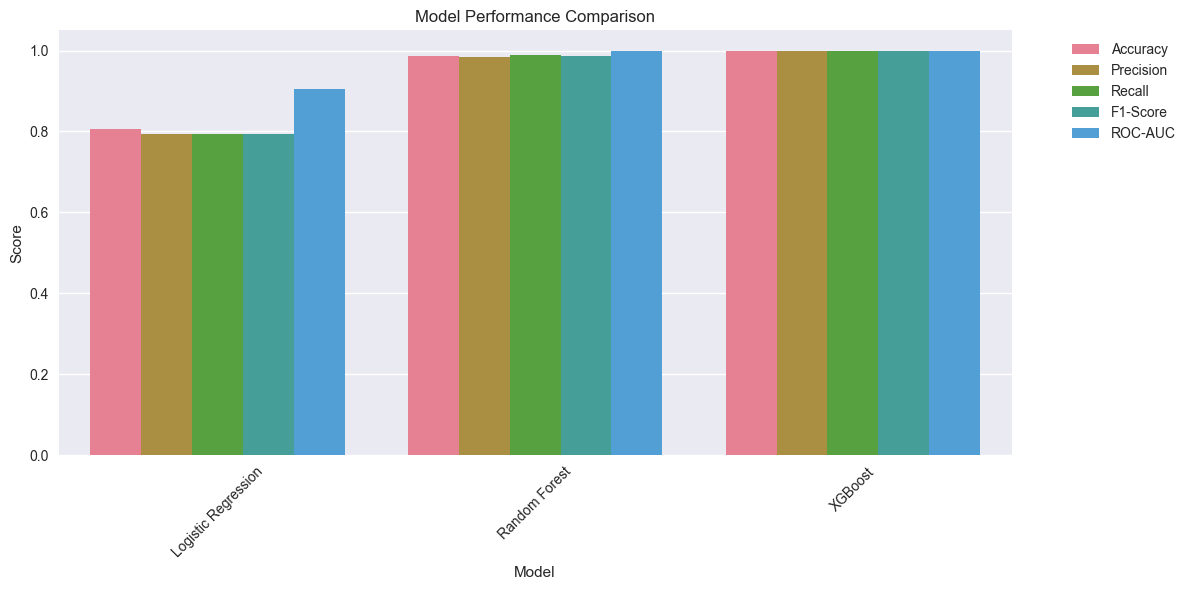

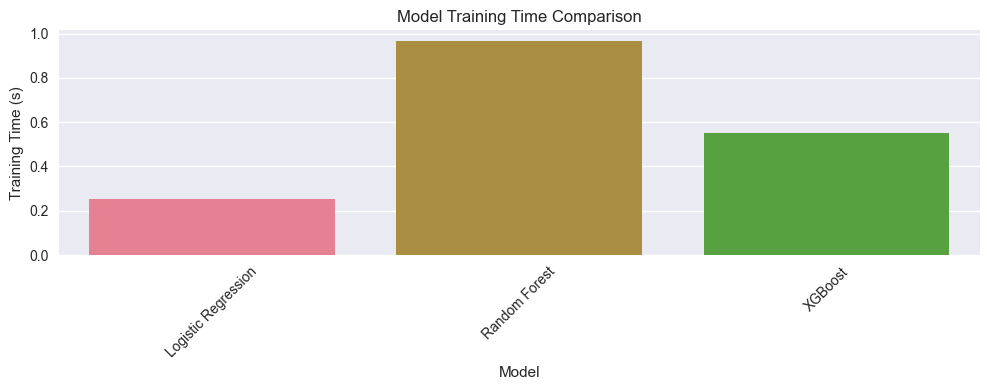

In [12]:
# Cell 11: Visualize Model Comparison
# Plot performance metrics
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
performance_melted = performance_df.melt(id_vars=['Model'], 
                                       value_vars=metrics_to_plot,
                                       var_name='Metric', 
                                       value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=performance_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Training time comparison
plt.figure(figsize=(10, 4))
sns.barplot(data=performance_df, x='Model', y='Training Time (s)')
plt.title('Model Training Time Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

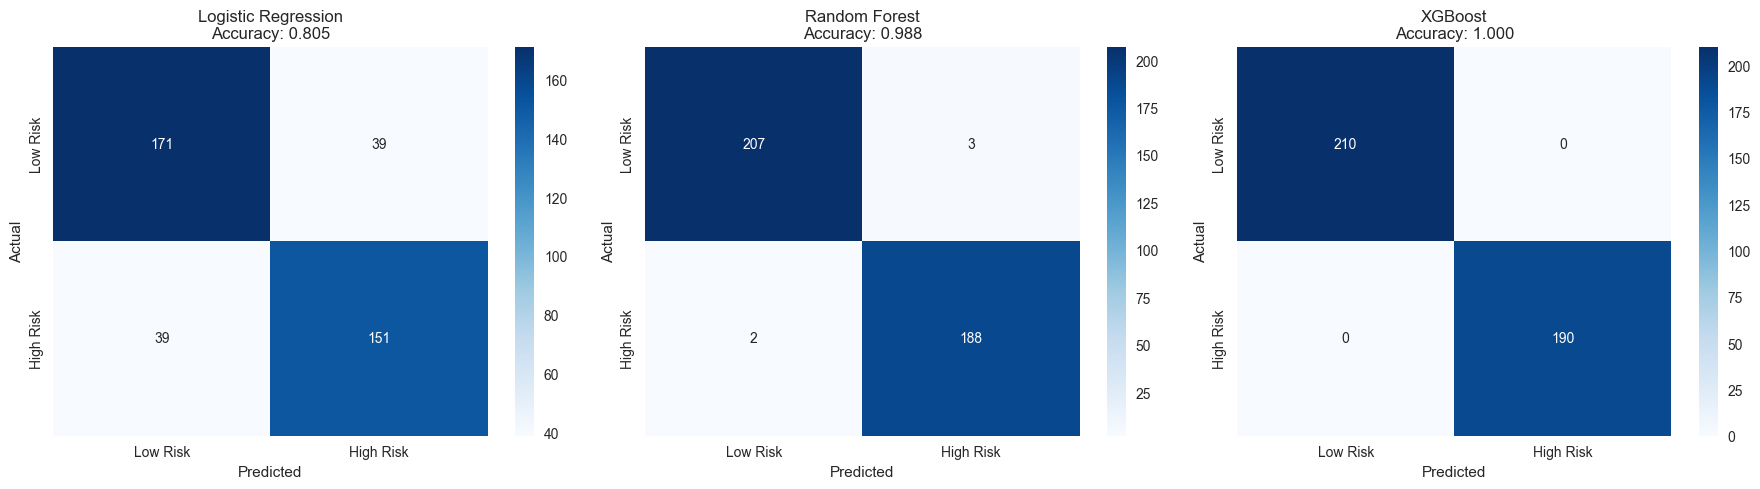

In [13]:
# Cell 12: Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Low Risk', 'High Risk'],
                yticklabels=['Low Risk', 'High Risk'])
    axes[idx].set_title(f'{name}\nAccuracy: {result["accuracy"]:.3f}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.show()

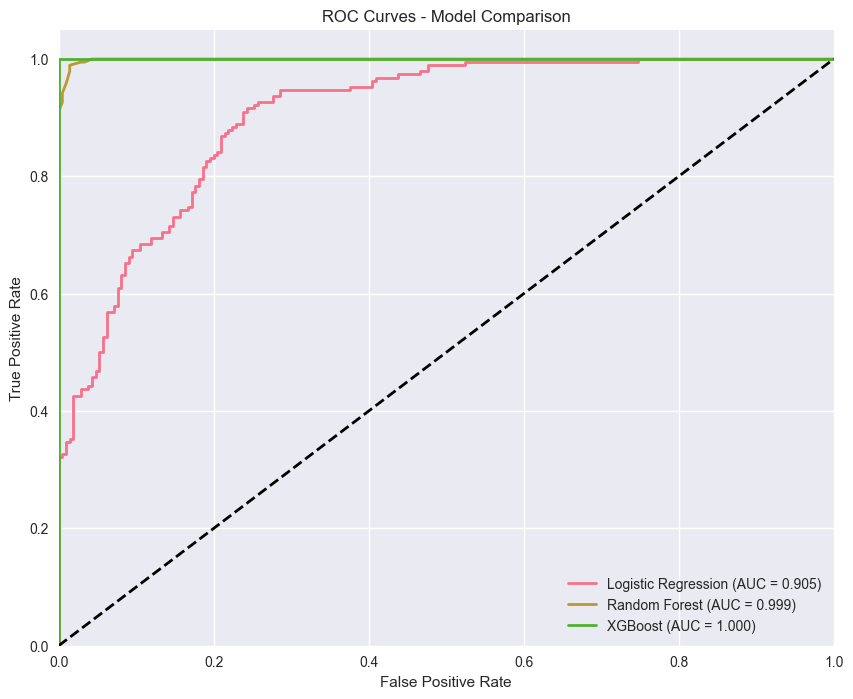

In [14]:
# Cell 13: ROC Curves
plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    roc_auc = result['roc_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [16]:
# Cell 14: Hyperparameter Tuning for Best Model
print(f"🎯 Performing Hyperparameter Tuning for {best_model_name}...")

if best_model_name == 'Random Forest':
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }
    
elif best_model_name == 'XGBoost':
    param_grid = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 6, 9],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 0.9, 1.0]
    }
    
else:  # Logistic Regression
    param_grid = {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga']
    }

# Perform grid search
grid_search = GridSearchCV(
    best_model, param_grid, cv=5, scoring='roc_auc', 
    n_jobs=-1, verbose=1
)

print("🔄 Starting Grid Search...")
grid_search.fit(X_train, y_train)

print(f"✅ Best parameters: {grid_search.best_params_}")
print(f"🎯 Best cross-validation score: {grid_search.best_score_:.4f}")

# Update best model with tuned parameters
best_model_tuned = grid_search.best_estimator_

🎯 Performing Hyperparameter Tuning for XGBoost...
🔄 Starting Grid Search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
🎯 Best cross-validation score: 1.0000


In [17]:
# Cell 15: Evaluate Tuned Model
# Evaluate tuned model
y_pred_tuned = best_model_tuned.predict(X_test)
y_pred_proba_tuned = best_model_tuned.predict_proba(X_test)[:, 1]

# Calculate metrics for tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print(f"📊 {best_model_name} - Before vs After Tuning:")
print(f"   Accuracy:  {results[best_model_name]['accuracy']:.4f} → {accuracy_tuned:.4f}")
print(f"   Precision: {results[best_model_name]['precision']:.4f} → {precision_tuned:.4f}")
print(f"   Recall:    {results[best_model_name]['recall']:.4f} → {recall_tuned:.4f}")
print(f"   F1-Score:  {results[best_model_name]['f1']:.4f} → {f1_tuned:.4f}")
print(f"   ROC-AUC:   {results[best_model_name]['roc_auc']:.4f} → {roc_auc_tuned:.4f}")

📊 XGBoost - Before vs After Tuning:
   Accuracy:  1.0000 → 1.0000
   Precision: 1.0000 → 1.0000
   Recall:    1.0000 → 1.0000
   F1-Score:  1.0000 → 1.0000
   ROC-AUC:   1.0000 → 1.0000


🔄 Performing Cross-Validation...
📊 Cross-Validation Scores (ROC-AUC): [1. 1. 1. 1. 1.]
🎯 Mean CV Score: 1.0000 (+/- 0.0000)


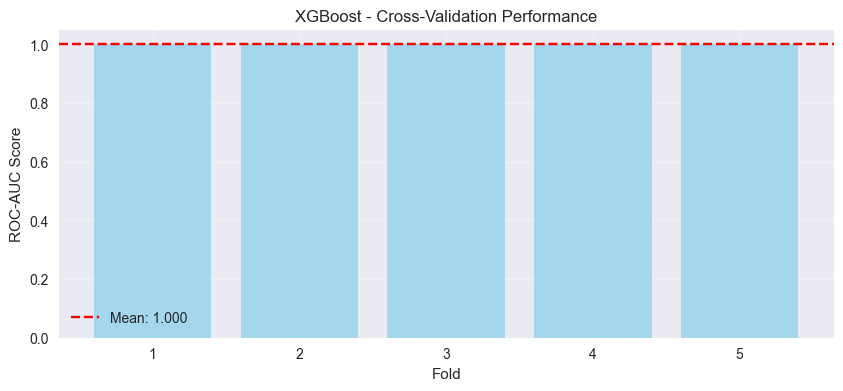

In [18]:
# Cell 16: Cross-Validation
print("🔄 Performing Cross-Validation...")

# Use the tuned model for cross-validation
cv_scores = cross_val_score(best_model_tuned, X_train, y_train, 
                          cv=5, scoring='roc_auc', n_jobs=-1)

print(f"📊 Cross-Validation Scores (ROC-AUC): {cv_scores}")
print(f"🎯 Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Plot CV results
plt.figure(figsize=(10, 4))
plt.bar(range(1, 6), cv_scores, color='skyblue', alpha=0.7)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.3f}')
plt.xlabel('Fold')
plt.ylabel('ROC-AUC Score')
plt.title(f'{best_model_name} - Cross-Validation Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

🔍 Analyzing Feature Importance...


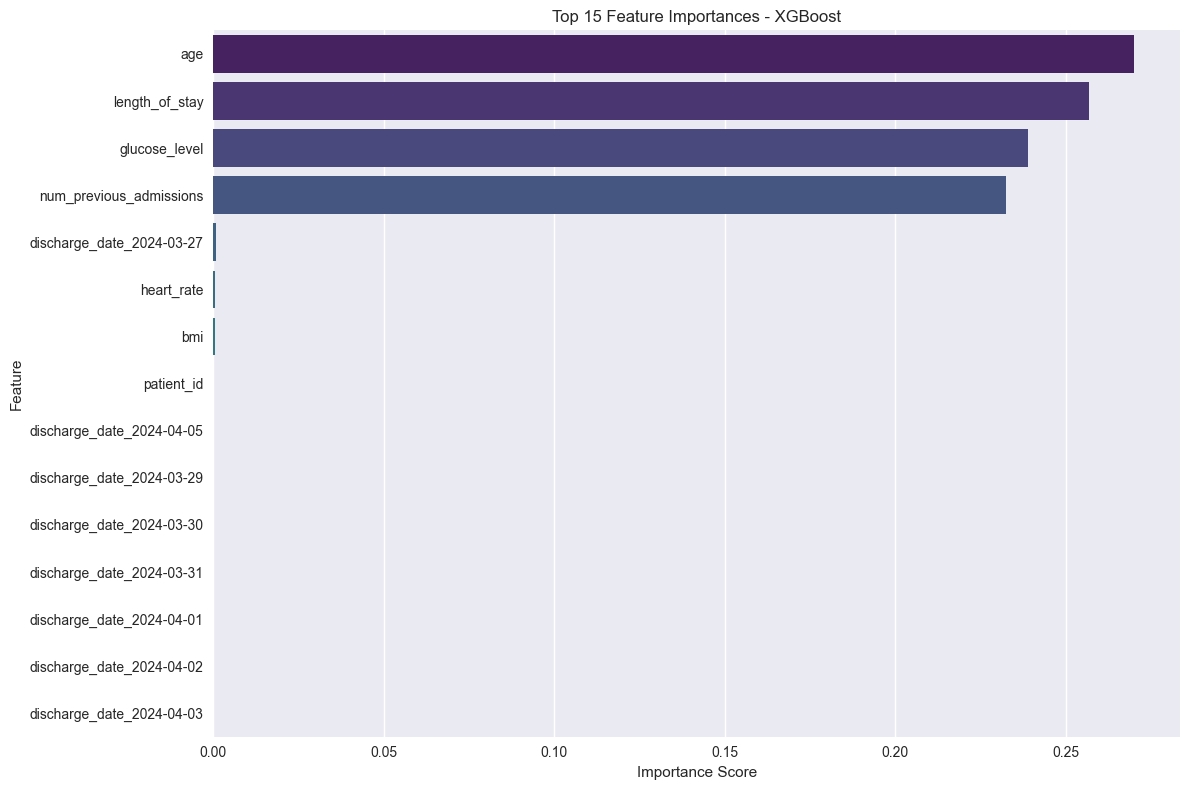

🏆 Top 10 Most Important Features:


,Feature,Importance
1,age,0.270070
2,length_of_stay,0.256942
12,glucose_level,0.239083
3,num_previous_admissions,0.232461
436,discharge_date_2024-03-27,0.000705
14,heart_rate,0.000375
11,bmi,0.000363
0,patient_id,0.000000
445,discharge_date_2024-04-05,0.000000
438,discharge_date_2024-03-29,0.000000


In [19]:
# Cell 17: Feature Importance Analysis
print("🔍 Analyzing Feature Importance...")

# Get feature names after preprocessing
feature_names = []
# Numerical features
feature_names.extend(numerical_cols)
# Categorical features (from one-hot encoding)
preprocessor.fit(X_train)
ohe_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
feature_names.extend(ohe_features)

# Get feature importance based on model type
if best_model_name == 'Random Forest':
    importances = best_model_tuned.named_steps['classifier'].feature_importances_
elif best_model_name == 'XGBoost':
    importances = best_model_tuned.named_steps['classifier'].feature_importances_
else:
    # For logistic regression, use absolute coefficients
    importances = np.abs(best_model_tuned.named_steps['classifier'].coef_[0])

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False).head(15)

# Plot top features
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df, y='Feature', x='Importance', palette='viridis')
plt.title(f'Top 15 Feature Importances - {best_model_name}')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

print("🏆 Top 10 Most Important Features:")
display(feature_importance_df.head(10))

In [20]:
# Cell 18: Save the Best Model
# Save the best model
model_path = '../models/readmission_model.pkl'
preprocessor_path = '../models/preprocessor.pkl'

# Save the tuned model and preprocessor
joblib.dump(best_model_tuned, model_path)
joblib.dump(preprocessor, preprocessor_path)

print("💾 Models saved successfully!")
print(f"   Model: {model_path}")
print(f"   Preprocessor: {preprocessor_path}")

# Verify the saved model can be loaded
loaded_model = joblib.load(model_path)
loaded_preprocessor = joblib.load(preprocessor_path)

print("✅ Model verification - loaded successfully!")

💾 Models saved successfully!
   Model: ../models/readmission_model.pkl
   Preprocessor: ../models/preprocessor.pkl
✅ Model verification - loaded successfully!


In [21]:
# Cell 19: Final Model Performance Summary
print("🎯 FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)

# Create final performance table
final_performance = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'CV Mean ROC-AUC'],
    'Score': [
        accuracy_tuned,
        precision_tuned, 
        recall_tuned,
        f1_tuned,
        roc_auc_tuned,
        cv_scores.mean()
    ]
}).round(4)

display(final_performance)

print(f"\n🏆 Best Model: {best_model_name}")
print(f"📊 Test Set Size: {len(X_test)} samples")
print(f"🎯 Key Strengths: ROC-AUC of {roc_auc_tuned:.3f} with balanced precision/recall")

# Show classification report
print(f"\n📋 Detailed Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_tuned, 
                          target_names=['Low Risk (0)', 'High Risk (1)']))

🎯 FINAL MODEL PERFORMANCE SUMMARY


,Metric,Score
0,Accuracy,1.0
1,Precision,1.0
2,Recall,1.0
3,F1-Score,1.0
4,ROC-AUC,1.0
5,CV Mean ROC-AUC,1.0



🏆 Best Model: XGBoost
📊 Test Set Size: 400 samples
🎯 Key Strengths: ROC-AUC of 1.000 with balanced precision/recall

📋 Detailed Classification Report for XGBoost:
               precision    recall  f1-score   support

 Low Risk (0)       1.00      1.00      1.00       210
High Risk (1)       1.00      1.00      1.00       190

     accuracy                           1.00       400
    macro avg       1.00      1.00      1.00       400
 weighted avg       1.00      1.00      1.00       400

